#Install Pytorch Geometric and Open Graph Benchmark:

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 200})'''))
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

#pytorch geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#open graph benchmark
!pip install -q ogb

<IPython.core.display.Javascript object>

2.0.1+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


#Download and process data
We use the dataset provided by OGB and their scaffold split

In [ ]:
import torch
torch.manual_seed(137)
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.loader import DataLoader

# download data to './dataset/ogbg_molhiv/'
dataset = PygGraphPropPredDataset(name = "ogbg-molhiv", root = 'dataset/')

# use the scaffold split indices of OGB to instantiate PyTorch Geometric dataloaders
split_idx = dataset.get_idx_split()
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True)
val_loader = DataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=False)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=False)

# Understand the data
Let us investigate a single data sample, i.e., a single molecule which is represented as PyG dataclass.


In [ ]:
molecule = dataset[0]
molecule

Data(edge_index=[2, 40], edge_attr=[40, 3], x=[19, 9], y=[1, 1], num_nodes=19)

It contains 19 atoms/nodes. The edge index specifies the graph topology. Each node comes with 9 features about, e.g., the atom type in the entry 'x' and the label of whether or not the molecule inhits HIV replication is stored in 'y'.

In [ ]:
molecule['x'] # The features of the nodes. The initial column contains the atom type.

tensor([[ 5,  0,  4,  5,  3,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  0],
        [ 5,  0,  3,  5,  0,  0,  1,  0,  1],
        [ 7,  0,  2,  6,  0,  0,  1,  0,  1],
        [28,  0,  4,  2,  0,  0,  5,  0,  1],
        [ 7,  0,  2,  6,  0,  0,  1,  0,  1],
        [ 5,  0,  3,  5,  0,  0,  1,  0,  1],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  3,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  1],
        [ 7,  0,  2,  6,  0,  0,  1,  0,  1],
        [ 5,  0,  3,  5,  0,  0,  1,  0,  1],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  3,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  1],
        [ 5,  0,  3,  5,  0,  0,  1,  0,  1],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  3,  0,  2,  0,  0],
        [ 7,  0,  2,  6,  0,  0,  1,  0,  1]])

In [ ]:
molecule['edge_index'] # The bonds of the molecuel given by two lists of node indices. We find (0,1), (1,0), (1,2) ... as edges. Note the bidirectional edges.

tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  6,  9,
          4, 10, 10, 11, 11, 12, 12, 13, 11, 14, 14, 15, 15, 16, 16, 17, 15, 18,
          9,  2, 18,  4],
        [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  6,
         10,  4, 11, 10, 12, 11, 13, 12, 14, 11, 15, 14, 16, 15, 17, 16, 18, 15,
          2,  9,  4, 18]])

In [ ]:
molecule['y'] # 0 or 1 for whether or not the molecule inhibits HIV growth

tensor([[0]])

# Build the GNN
To process the molecular graphs we first produce initial node features $h_i^{(0} \in \mathbb{R}^{64}$ of the atom/node $v_i$ by representing its atom descriptors with a learnable embedding. The permutation invariant aggregation function $\rho$ for our GNN layer is summation, $\mu$ is the identity and leaves the summed features unchanged, and $\rho: \mathbb{R}^{64}\times\mathbb{R}^{64} \mapsto \mathbb{R}^{64}$ is given by $\rho(h_i^{(l)}, h)=\phi(h_i^{(l)} + h)$ where $\phi$ is a single layer feedforward network with ReLU as nonlinearity. We apply 4 such message-passing layers to arrive at new node features capturing information from a 4-hop neighborhood in the graph. To obtain a final logit for the purpose of our graph classification task, we pool the features of each node by summing them and feeding them through a multi-layer perceptron with output dimensionality 1.

In [ ]:
# hyperparameters
num_layers = 4
hidden_dim = 64

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GINConv
from torch_geometric.nn import global_add_pool
from ogb.graphproppred.mol_encoder import AtomEncoder
import torch.nn as nn


class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        # to embed the 9 features of each atom
        self.atom_embedder = AtomEncoder(hidden_dim)
        self.layers = nn.ModuleList()
        for i in range(num_layers):
          feedforward_rho = nn.Sequential(Linear(hidden_dim, hidden_dim),
                                          nn.ReLU())
          self.layers.append(GINConv(nn=feedforward_rho))
        self.final_feedforward = Linear(hidden_dim, 1)

    def forward(self, x, edge_index, batch):
        h = self.atom_embedder(x)
        for layer in self.layers:
          h = layer(h, edge_index)

        h = global_add_pool(h, batch)  # [batch_size, hidden_dim]
        h = self.final_feedforward(h)
        return h
dummy_model = GNN()
print(dummy_model)

GNN(
  (atom_embedder): AtomEncoder(
    (atom_embedding_list): ModuleList(
      (0): Embedding(119, 64)
      (1): Embedding(5, 64)
      (2-3): 2 x Embedding(12, 64)
      (4): Embedding(10, 64)
      (5-6): 2 x Embedding(6, 64)
      (7-8): 2 x Embedding(2, 64)
    )
  )
  (layers): ModuleList(
    (0-3): 4 x GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
    ))
  )
  (final_feedforward): Linear(in_features=64, out_features=1, bias=True)
)


# Train the model
First we set up the training and evaluation functions that iterate over the data using Binary Cross Entropy Loss, the Adam Optimizer, and the evaluator with ROC-AUC from the OGB library.

In [ ]:
from ogb.graphproppred import Evaluator
from tqdm.notebook import tqdm
import numpy as np
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

loss_function = torch.nn.BCEWithLogitsLoss()
evaluator = Evaluator('ogbg-molhiv')

def run_epoch(model, optimizer, loader):
    model.train()
    y_true = []
    y_pred = []
    losses = []
    for step, data in enumerate(tqdm(loader, desc="Iteration")):  # Iterate in batches over the training dataset.
      pred = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.

      loss = loss_function(pred, data.y.to(torch.float32))  # Compute the loss.
      if optimizer is not None:
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
      losses.append(loss.detach().cpu().numpy())
      y_true.append(data.y.view(pred.shape).detach().cpu())
      y_pred.append(pred.detach().cpu())
    y_true = torch.cat(y_true, dim = 0).numpy()
    y_pred = torch.cat(y_pred, dim = 0).numpy()
    input_dict = {"y_true": y_true, "y_pred": y_pred}
    return np.array(losses).mean(), evaluator.eval(input_dict)['rocauc']

<IPython.core.display.Javascript object>

Now we run training!
Feel free to set a different number of epochs for this to be faster/slower or try a different learning rate.


In [ ]:
num_epochs = 100
model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import copy
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
train_aucs = []
val_aucs = []
best_model = None
best_val_auc = 0
for epoch in range(1, num_epochs+1):
    train_loss, train_auc = run_epoch(model, optimizer, train_loader)
    val_loss, val_auc = run_epoch(model, None, val_loader)
    print(f'Epoch: {epoch:03d}, Train loss: {train_loss:.4f}, Train ROC-AUC: {train_auc:.4f}, Val loss: {val_loss:.4f}, Val ROC-AUC: {val_auc:.4f}')
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)
    if val_auc > best_val_auc:
      best_val_auc = val_auc
      best_model = copy.deepcopy(model)

<IPython.core.display.Javascript object>

Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 001, Train loss: 0.2740, Train ROC-AUC: 0.4901, Val loss: 0.1952, Val ROC-AUC: 0.5590


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 002, Train loss: 0.1947, Train ROC-AUC: 0.5357, Val loss: 0.1328, Val ROC-AUC: 0.5588


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 003, Train loss: 0.1722, Train ROC-AUC: 0.6129, Val loss: 0.1118, Val ROC-AUC: 0.6189


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 004, Train loss: 0.1609, Train ROC-AUC: 0.6491, Val loss: 0.1164, Val ROC-AUC: 0.5544


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 005, Train loss: 0.1541, Train ROC-AUC: 0.6695, Val loss: 0.1070, Val ROC-AUC: 0.6205


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 006, Train loss: 0.1486, Train ROC-AUC: 0.6884, Val loss: 0.1043, Val ROC-AUC: 0.6251


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 007, Train loss: 0.1452, Train ROC-AUC: 0.6982, Val loss: 0.0967, Val ROC-AUC: 0.6367


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 008, Train loss: 0.1416, Train ROC-AUC: 0.7051, Val loss: 0.0953, Val ROC-AUC: 0.6934


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 009, Train loss: 0.1415, Train ROC-AUC: 0.7090, Val loss: 0.0946, Val ROC-AUC: 0.6710


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 010, Train loss: 0.1371, Train ROC-AUC: 0.7364, Val loss: 0.1022, Val ROC-AUC: 0.7074


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 011, Train loss: 0.1370, Train ROC-AUC: 0.7279, Val loss: 0.0897, Val ROC-AUC: 0.6904


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 012, Train loss: 0.1362, Train ROC-AUC: 0.7374, Val loss: 0.0863, Val ROC-AUC: 0.7239


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 013, Train loss: 0.1335, Train ROC-AUC: 0.7495, Val loss: 0.0855, Val ROC-AUC: 0.7206


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 014, Train loss: 0.1368, Train ROC-AUC: 0.7505, Val loss: 0.0836, Val ROC-AUC: 0.7423


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 015, Train loss: 0.1321, Train ROC-AUC: 0.7561, Val loss: 0.0861, Val ROC-AUC: 0.7080


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 016, Train loss: 0.1321, Train ROC-AUC: 0.7605, Val loss: 0.0892, Val ROC-AUC: 0.7338


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 017, Train loss: 0.1311, Train ROC-AUC: 0.7690, Val loss: 0.0884, Val ROC-AUC: 0.6694


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 018, Train loss: 0.1307, Train ROC-AUC: 0.7674, Val loss: 0.0900, Val ROC-AUC: 0.7164


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 019, Train loss: 0.1297, Train ROC-AUC: 0.7632, Val loss: 0.0832, Val ROC-AUC: 0.7107


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 020, Train loss: 0.1285, Train ROC-AUC: 0.7748, Val loss: 0.0819, Val ROC-AUC: 0.7539


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 021, Train loss: 0.1279, Train ROC-AUC: 0.7707, Val loss: 0.0852, Val ROC-AUC: 0.6875


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 022, Train loss: 0.1248, Train ROC-AUC: 0.7825, Val loss: 0.0795, Val ROC-AUC: 0.7631


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 023, Train loss: 0.1247, Train ROC-AUC: 0.7902, Val loss: 0.0820, Val ROC-AUC: 0.7680


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 024, Train loss: 0.1258, Train ROC-AUC: 0.7799, Val loss: 0.0939, Val ROC-AUC: 0.7508


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 025, Train loss: 0.1230, Train ROC-AUC: 0.7834, Val loss: 0.0840, Val ROC-AUC: 0.7179


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 026, Train loss: 0.1230, Train ROC-AUC: 0.7849, Val loss: 0.0840, Val ROC-AUC: 0.7705


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 027, Train loss: 0.1223, Train ROC-AUC: 0.7888, Val loss: 0.0780, Val ROC-AUC: 0.7796


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 028, Train loss: 0.1216, Train ROC-AUC: 0.7948, Val loss: 0.0931, Val ROC-AUC: 0.7277


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 029, Train loss: 0.1223, Train ROC-AUC: 0.7849, Val loss: 0.0787, Val ROC-AUC: 0.7549


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 030, Train loss: 0.1186, Train ROC-AUC: 0.7977, Val loss: 0.0832, Val ROC-AUC: 0.7539


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 031, Train loss: 0.1190, Train ROC-AUC: 0.8070, Val loss: 0.0879, Val ROC-AUC: 0.7004


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 032, Train loss: 0.1207, Train ROC-AUC: 0.8010, Val loss: 0.0985, Val ROC-AUC: 0.7571


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 033, Train loss: 0.1192, Train ROC-AUC: 0.8049, Val loss: 0.0871, Val ROC-AUC: 0.7736


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 034, Train loss: 0.1169, Train ROC-AUC: 0.8014, Val loss: 0.0849, Val ROC-AUC: 0.7670


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 035, Train loss: 0.1181, Train ROC-AUC: 0.8026, Val loss: 0.0947, Val ROC-AUC: 0.7428


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 036, Train loss: 0.1175, Train ROC-AUC: 0.8060, Val loss: 0.0955, Val ROC-AUC: 0.7349


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 037, Train loss: 0.1179, Train ROC-AUC: 0.8084, Val loss: 0.0886, Val ROC-AUC: 0.7563


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 038, Train loss: 0.1174, Train ROC-AUC: 0.8013, Val loss: 0.0892, Val ROC-AUC: 0.7552


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 039, Train loss: 0.1157, Train ROC-AUC: 0.8065, Val loss: 0.0806, Val ROC-AUC: 0.7313


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 040, Train loss: 0.1159, Train ROC-AUC: 0.8081, Val loss: 0.0876, Val ROC-AUC: 0.7335


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 041, Train loss: 0.1165, Train ROC-AUC: 0.8126, Val loss: 0.0861, Val ROC-AUC: 0.7485


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 042, Train loss: 0.1165, Train ROC-AUC: 0.8049, Val loss: 0.0992, Val ROC-AUC: 0.7136


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 043, Train loss: 0.1156, Train ROC-AUC: 0.8067, Val loss: 0.0856, Val ROC-AUC: 0.7338


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 044, Train loss: 0.1137, Train ROC-AUC: 0.8123, Val loss: 0.0872, Val ROC-AUC: 0.7381


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 045, Train loss: 0.1156, Train ROC-AUC: 0.8176, Val loss: 0.0903, Val ROC-AUC: 0.7241


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 046, Train loss: 0.1163, Train ROC-AUC: 0.8053, Val loss: 0.1057, Val ROC-AUC: 0.7643


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 047, Train loss: 0.1125, Train ROC-AUC: 0.8172, Val loss: 0.1314, Val ROC-AUC: 0.7525


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 048, Train loss: 0.1142, Train ROC-AUC: 0.8225, Val loss: 0.0842, Val ROC-AUC: 0.7627


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 049, Train loss: 0.1137, Train ROC-AUC: 0.8198, Val loss: 0.1121, Val ROC-AUC: 0.7525


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 050, Train loss: 0.1158, Train ROC-AUC: 0.8166, Val loss: 0.1508, Val ROC-AUC: 0.7603


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 051, Train loss: 0.1139, Train ROC-AUC: 0.8195, Val loss: 0.1399, Val ROC-AUC: 0.7469


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 052, Train loss: 0.1173, Train ROC-AUC: 0.8174, Val loss: 0.0828, Val ROC-AUC: 0.7552


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 053, Train loss: 0.1119, Train ROC-AUC: 0.8178, Val loss: 0.0808, Val ROC-AUC: 0.7299


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 054, Train loss: 0.1181, Train ROC-AUC: 0.8126, Val loss: 0.0840, Val ROC-AUC: 0.7409


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 055, Train loss: 0.1148, Train ROC-AUC: 0.8112, Val loss: 0.0829, Val ROC-AUC: 0.7382


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 056, Train loss: 0.1117, Train ROC-AUC: 0.8187, Val loss: 0.0827, Val ROC-AUC: 0.6490


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 057, Train loss: 0.1133, Train ROC-AUC: 0.8168, Val loss: 0.0889, Val ROC-AUC: 0.7328


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 058, Train loss: 0.1119, Train ROC-AUC: 0.8190, Val loss: 0.0843, Val ROC-AUC: 0.7312


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 059, Train loss: 0.1110, Train ROC-AUC: 0.8211, Val loss: 0.0848, Val ROC-AUC: 0.7461


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 060, Train loss: 0.1101, Train ROC-AUC: 0.8269, Val loss: 0.1129, Val ROC-AUC: 0.7445


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 061, Train loss: 0.1186, Train ROC-AUC: 0.8190, Val loss: 0.0829, Val ROC-AUC: 0.7499


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 062, Train loss: 0.1125, Train ROC-AUC: 0.8224, Val loss: 0.0819, Val ROC-AUC: 0.7258


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 063, Train loss: 0.1094, Train ROC-AUC: 0.8238, Val loss: 0.0913, Val ROC-AUC: 0.7351


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 064, Train loss: 0.1114, Train ROC-AUC: 0.8276, Val loss: 0.0791, Val ROC-AUC: 0.7624


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 065, Train loss: 0.1137, Train ROC-AUC: 0.8201, Val loss: 0.0800, Val ROC-AUC: 0.7475


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 066, Train loss: 0.1107, Train ROC-AUC: 0.8208, Val loss: 0.0838, Val ROC-AUC: 0.7396


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 067, Train loss: 0.1094, Train ROC-AUC: 0.8261, Val loss: 0.0851, Val ROC-AUC: 0.6990


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 068, Train loss: 0.1102, Train ROC-AUC: 0.8284, Val loss: 0.0835, Val ROC-AUC: 0.7175


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 069, Train loss: 0.1119, Train ROC-AUC: 0.8227, Val loss: 0.1074, Val ROC-AUC: 0.7372


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 070, Train loss: 0.1109, Train ROC-AUC: 0.8207, Val loss: 0.0991, Val ROC-AUC: 0.7210


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 071, Train loss: 0.1117, Train ROC-AUC: 0.8184, Val loss: 0.1539, Val ROC-AUC: 0.7141


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 072, Train loss: 0.1105, Train ROC-AUC: 0.8218, Val loss: 0.1190, Val ROC-AUC: 0.7208


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 073, Train loss: 0.1090, Train ROC-AUC: 0.8238, Val loss: 0.1011, Val ROC-AUC: 0.7325


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 074, Train loss: 0.1134, Train ROC-AUC: 0.8148, Val loss: 0.0842, Val ROC-AUC: 0.7545


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 075, Train loss: 0.1089, Train ROC-AUC: 0.8263, Val loss: 0.0900, Val ROC-AUC: 0.7440


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 076, Train loss: 0.1097, Train ROC-AUC: 0.8231, Val loss: 0.0816, Val ROC-AUC: 0.7533


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 077, Train loss: 0.1085, Train ROC-AUC: 0.8333, Val loss: 0.0876, Val ROC-AUC: 0.7281


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 078, Train loss: 0.1105, Train ROC-AUC: 0.8294, Val loss: 0.0991, Val ROC-AUC: 0.7151


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 079, Train loss: 0.1073, Train ROC-AUC: 0.8316, Val loss: 0.1112, Val ROC-AUC: 0.7323


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 080, Train loss: 0.1091, Train ROC-AUC: 0.8290, Val loss: 0.2831, Val ROC-AUC: 0.7398


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 081, Train loss: 0.1086, Train ROC-AUC: 0.8290, Val loss: 0.1798, Val ROC-AUC: 0.7421


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 082, Train loss: 0.1088, Train ROC-AUC: 0.8286, Val loss: 0.8448, Val ROC-AUC: 0.7512


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 083, Train loss: 0.1087, Train ROC-AUC: 0.8306, Val loss: 0.1854, Val ROC-AUC: 0.7697


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 084, Train loss: 0.1114, Train ROC-AUC: 0.8328, Val loss: 0.3530, Val ROC-AUC: 0.7316


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 085, Train loss: 0.1088, Train ROC-AUC: 0.8257, Val loss: 0.9811, Val ROC-AUC: 0.7453


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 086, Train loss: 0.1116, Train ROC-AUC: 0.8205, Val loss: 0.1091, Val ROC-AUC: 0.7338


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 087, Train loss: 0.1128, Train ROC-AUC: 0.8251, Val loss: 0.1511, Val ROC-AUC: 0.7084


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 088, Train loss: 0.1080, Train ROC-AUC: 0.8288, Val loss: 0.5772, Val ROC-AUC: 0.7452


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 089, Train loss: 0.1079, Train ROC-AUC: 0.8277, Val loss: 0.8000, Val ROC-AUC: 0.7277


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 090, Train loss: 0.1137, Train ROC-AUC: 0.8239, Val loss: 0.1483, Val ROC-AUC: 0.7167


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 091, Train loss: 0.1086, Train ROC-AUC: 0.8257, Val loss: 1.1802, Val ROC-AUC: 0.7385


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 092, Train loss: 0.1078, Train ROC-AUC: 0.8363, Val loss: 2.1061, Val ROC-AUC: 0.7291


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 093, Train loss: 0.1087, Train ROC-AUC: 0.8264, Val loss: 2.0406, Val ROC-AUC: 0.7473


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 094, Train loss: 0.1092, Train ROC-AUC: 0.8232, Val loss: 2.9864, Val ROC-AUC: 0.7456


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 095, Train loss: 0.1085, Train ROC-AUC: 0.8264, Val loss: 5.0156, Val ROC-AUC: 0.7354


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 096, Train loss: 0.1112, Train ROC-AUC: 0.8222, Val loss: 3.1299, Val ROC-AUC: 0.7501


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 097, Train loss: 0.1110, Train ROC-AUC: 0.8279, Val loss: 0.4195, Val ROC-AUC: 0.7461


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 098, Train loss: 0.1045, Train ROC-AUC: 0.8326, Val loss: 1.3256, Val ROC-AUC: 0.7241


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 099, Train loss: 0.1121, Train ROC-AUC: 0.8279, Val loss: 0.3879, Val ROC-AUC: 0.7564


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 100, Train loss: 0.1261, Train ROC-AUC: 0.8254, Val loss: 0.0817, Val ROC-AUC: 0.7298


Let us take a look at the training curves and likely we will observe that the performance is better on the training set as we start overfitting it and the performance on the validation set is a bit worse since we are not overfitting on it. Keep in mind that the training and validation split is a random split, not a scaffold split as for the test data.

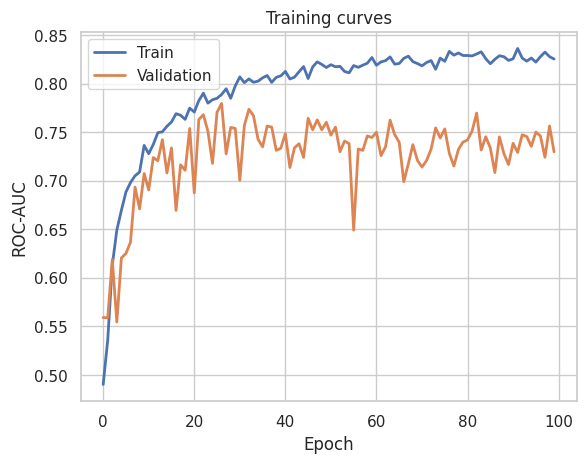

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
plt.plot(train_aucs, label="Train", linewidth=2)
plt.plot(val_aucs, label="Validation", linewidth=2)
plt.plot()

plt.xlabel("Epoch")
plt.ylabel("ROC-AUC")
plt.title("Training curves")
plt.legend()
plt.show()

# Evaluate the model on the test set

First, we run the predictions on the validation and on the test set. Likely we will observe that the performance on the test set is substantially worse than on the validation set. This is the case because the validation set is randomly split from the training data while the test set only has molecules with a different scaffold (main substructure) from the training data.


In [ ]:
train_loss, train_auc = run_epoch(best_model, None, train_loader)
val_loss, val_auc = run_epoch(best_model, None, val_loader)
test_loss, test_auc = run_epoch(best_model, None, test_loader)
print(f'Epoch: {epoch:03d}, Train ROC-AUC: {train_auc:.4f}, Val ROC-AUC: {val_auc:.4f}, Test ROC-AUC: {test_auc:.4f}')

Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 100, Train ROC-AUC: 0.7869, Val ROC-AUC: 0.7796, Test ROC-AUC: 0.7451


Now let us visualize the performance on the training data

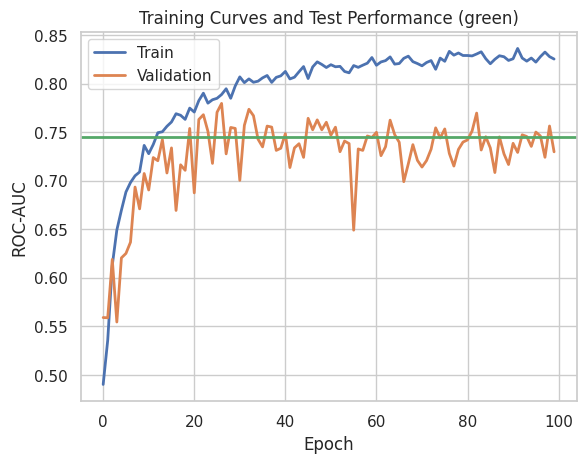

In [ ]:
plt.plot(train_aucs, label="Train", linewidth=2)
plt.plot(val_aucs, label="Validation", linewidth=2)
plt.axhline(y=test_auc, color='g', linewidth=2)
plt.plot()

plt.xlabel("Epoch")
plt.ylabel("ROC-AUC")
plt.title("Training Curves and Test Performance (green)")
plt.legend()
plt.show()

# Now we repeat the same with Morgan fingerprints and compare the performance

In [ ]:
#@title Function to convert graphs to Morgan Fingerprints
from typing import Any
import networkx as nx
import torch

import torch_geometric

x_map = {
    'atomic_num':
    list(range(0, 119)),
    'chirality': [
        'CHI_UNSPECIFIED',
        'CHI_TETRAHEDRAL_CW',
        'CHI_TETRAHEDRAL_CCW',
        'CHI_OTHER',
        'CHI_TETRAHEDRAL',
        'CHI_ALLENE',
        'CHI_SQUAREPLANAR',
        'CHI_TRIGONALBIPYRAMIDAL',
        'CHI_OCTAHEDRAL',
    ],
    'degree':
    list(range(0, 11)),
    'formal_charge':
    list(range(-5, 7)),
    'num_hs':
    list(range(0, 9)),
    'num_radical_electrons':
    list(range(0, 5)),
    'hybridization': [
        'UNSPECIFIED',
        'S',
        'SP',
        'SP2',
        'SP3',
        'SP3D',
        'SP3D2',
        'OTHER',
    ],
    'is_aromatic': [False, True],
    'is_in_ring': [False, True],
}

e_map = {
    'bond_type': [
        'UNSPECIFIED',
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'QUADRUPLE',
        'QUINTUPLE',
        'HEXTUPLE',
        'ONEANDAHALF',
        'TWOANDAHALF',
        'THREEANDAHALF',
        'FOURANDAHALF',
        'FIVEANDAHALF',
        'AROMATIC',
        'IONIC',
        'HYDROGEN',
        'THREECENTER',
        'DATIVEONE',
        'DATIVE',
        'DATIVEL',
        'DATIVER',
        'OTHER',
        'ZERO',
    ],
    'stereo': [
        'STEREONONE',
        'STEREOANY',
        'STEREOZ',
        'STEREOE',
        'STEREOCIS',
        'STEREOTRANS',
    ],
    'is_conjugated': [False, True],
}


def to_rdkit(data, kekulize: bool = False) -> Any:
    """Converts a :class:`torch_geometric.data.Data` instance to a SMILES
    string.

    Args:
        data (torch_geometric.data.Data): The molecular graph.
        kekulize (bool, optional): If set to :obj:`True`, converts aromatic
            bonds to single/double bonds. (default: :obj:`False`)
    """
    from rdkit import Chem

    mol = Chem.RWMol()

    for i in range(data.num_nodes):
        atom = Chem.Atom(data.x[i, 0].item())
        atom.SetChiralTag(Chem.rdchem.ChiralType.values[data.x[i, 1].item()])
        atom.SetFormalCharge(x_map['formal_charge'][data.x[i, 3].item()])
        atom.SetNumExplicitHs(x_map['num_hs'][data.x[i, 4].item()])
        atom.SetNumRadicalElectrons(
            x_map['num_radical_electrons'][data.x[i, 5].item()])
        atom.SetHybridization(
            Chem.rdchem.HybridizationType.values[data.x[i, 6].item()])
        atom.SetIsAromatic(data.x[i, 7].item())
        mol.AddAtom(atom)

    edges = [tuple(i) for i in data.edge_index.t().tolist()]
    visited = set()

    for i in range(len(edges)):
        src, dst = edges[i]
        if tuple(sorted(edges[i])) in visited:
            continue

        bond_type = Chem.BondType.values[data.edge_attr[i, 0].item()]
        mol.AddBond(src, dst, bond_type)

        # Set stereochemistry:
        stereo = Chem.rdchem.BondStereo.values[data.edge_attr[i, 1].item()]
        if stereo != Chem.rdchem.BondStereo.STEREONONE:
            db = mol.GetBondBetweenAtoms(src, dst)
            db.SetStereoAtoms(dst, src)
            db.SetStereo(stereo)

        # Set conjugation:
        is_conjugated = bool(data.edge_attr[i, 2].item())
        mol.GetBondBetweenAtoms(src, dst).SetIsConjugated(is_conjugated)

        visited.add(tuple(sorted(edges[i])))

    mol = mol.GetMol()

    if kekulize:
        Chem.Kekulize(mol)

    #Chem.SanitizeMol(mol)
    Chem.AssignStereochemistry(mol)

    return mol

In [ ]:
#@title Get Morgan Fingerprints
from tqdm.notebook import tqdm
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
fingerprints = []
labels = []
fpgen = GetMorganGenerator(radius=2)

for molecule in tqdm(dataset):
  rd_mol = to_rdkit(molecule, True)
  fp = fpgen.GetFingerprint(rd_mol)
  fingerprints.append(torch.tensor(fp))
  labels.append(molecule.y)

  0%|          | 0/41127 [00:00<?, ?it/s]

In [ ]:
fingerprint_tensor = torch.stack(fingerprints).float()
labels_tensor = torch.stack(labels).float()
fptrain_loader = DataLoader(torch.utils.data.TensorDataset(fingerprint_tensor[split_idx["train"]], labels_tensor[split_idx["train"]]), batch_size=32, shuffle=True)
fpval_loader = DataLoader(torch.utils.data.TensorDataset(fingerprint_tensor[split_idx["valid"]], labels_tensor[split_idx["valid"]]), batch_size=32, shuffle=False)
fptest_loader = DataLoader(torch.utils.data.TensorDataset(fingerprint_tensor[split_idx["test"]], labels_tensor[split_idx["test"]]), batch_size=32, shuffle=False)

In [ ]:
from ogb.graphproppred import Evaluator
from tqdm.notebook import tqdm
import numpy as np
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

loss_function = torch.nn.BCEWithLogitsLoss()
evaluator = Evaluator('ogbg-molhiv')

def run_fpepoch(model, optimizer, loader):
    fpmodel.train()
    y_true = []
    y_pred = []
    losses = []
    for step, data in enumerate(tqdm(loader, desc="Iteration")):  # Iterate in batches over the training dataset.
      fingerprint, target = data
      pred = model(fingerprint)  # Perform a single forward pass.

      loss = loss_function(pred, target.squeeze(2).to(torch.float32))  # Compute the loss.
      if optimizer is not None:
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
      losses.append(loss.detach().cpu().numpy())
      y_true.append(target.view(pred.shape).detach().cpu())
      y_pred.append(pred.detach().cpu())
    y_true = torch.cat(y_true, dim = 0).numpy()
    y_pred = torch.cat(y_pred, dim = 0).numpy()
    input_dict = {"y_true": y_true, "y_pred": y_pred}
    return np.array(losses).mean(), evaluator.eval(input_dict)['rocauc']

<IPython.core.display.Javascript object>

In [ ]:
import torch.nn as nn
num_epochs = 30
fpmodel = nn.Sequential(
    nn.Linear(2048, 100),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(100, 1)
)
fpoptimizer = torch.optim.Adam(fpmodel.parameters(), lr=0.001)

In [ ]:
import copy
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
fptrain_aucs = []
fpval_aucs = []
fpbest_model = None
fpbest_val_auc = 0
for epoch in range(1, num_epochs+1):
    train_loss, train_auc = run_fpepoch(fpmodel, fpoptimizer, fptrain_loader)
    val_loss, val_auc = run_fpepoch(fpmodel, None, fpval_loader)
    print(f'Epoch: {epoch:03d}, Train loss: {train_loss:.4f}, Train ROC-AUC: {train_auc:.4f}, Val loss: {val_loss:.4f}, Val ROC-AUC: {val_auc:.4f}')
    fptrain_aucs.append(train_auc)
    fpval_aucs.append(val_auc)
    if val_auc > fpbest_val_auc:
      fpbest_val_auc = val_auc
      fpbest_model = copy.deepcopy(fpmodel)

<IPython.core.display.Javascript object>

Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 001, Train loss: 0.1446, Train ROC-AUC: 0.7354, Val loss: 0.0884, Val ROC-AUC: 0.7251


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 002, Train loss: 0.1071, Train ROC-AUC: 0.8591, Val loss: 0.0854, Val ROC-AUC: 0.7598


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 003, Train loss: 0.0943, Train ROC-AUC: 0.9023, Val loss: 0.0834, Val ROC-AUC: 0.7556


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 004, Train loss: 0.0861, Train ROC-AUC: 0.9249, Val loss: 0.0831, Val ROC-AUC: 0.7710


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 005, Train loss: 0.0791, Train ROC-AUC: 0.9401, Val loss: 0.0860, Val ROC-AUC: 0.7697


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 006, Train loss: 0.0727, Train ROC-AUC: 0.9515, Val loss: 0.0911, Val ROC-AUC: 0.7678


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 007, Train loss: 0.0673, Train ROC-AUC: 0.9609, Val loss: 0.0923, Val ROC-AUC: 0.7733


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 008, Train loss: 0.0626, Train ROC-AUC: 0.9676, Val loss: 0.0995, Val ROC-AUC: 0.7557


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 009, Train loss: 0.0563, Train ROC-AUC: 0.9765, Val loss: 0.1059, Val ROC-AUC: 0.7597


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 010, Train loss: 0.0518, Train ROC-AUC: 0.9806, Val loss: 0.1140, Val ROC-AUC: 0.7505


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 011, Train loss: 0.0465, Train ROC-AUC: 0.9858, Val loss: 0.1129, Val ROC-AUC: 0.7628


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 012, Train loss: 0.0429, Train ROC-AUC: 0.9884, Val loss: 0.1304, Val ROC-AUC: 0.7557


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 013, Train loss: 0.0394, Train ROC-AUC: 0.9910, Val loss: 0.1429, Val ROC-AUC: 0.7506


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 014, Train loss: 0.0347, Train ROC-AUC: 0.9940, Val loss: 0.1461, Val ROC-AUC: 0.7491


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 015, Train loss: 0.0311, Train ROC-AUC: 0.9955, Val loss: 0.1623, Val ROC-AUC: 0.7518


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 016, Train loss: 0.0280, Train ROC-AUC: 0.9963, Val loss: 0.1708, Val ROC-AUC: 0.7459


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 017, Train loss: 0.0256, Train ROC-AUC: 0.9971, Val loss: 0.1935, Val ROC-AUC: 0.7321


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 018, Train loss: 0.0235, Train ROC-AUC: 0.9974, Val loss: 0.1940, Val ROC-AUC: 0.7448


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 019, Train loss: 0.0197, Train ROC-AUC: 0.9981, Val loss: 0.2110, Val ROC-AUC: 0.7294


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 020, Train loss: 0.0188, Train ROC-AUC: 0.9986, Val loss: 0.2426, Val ROC-AUC: 0.7253


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 021, Train loss: 0.0178, Train ROC-AUC: 0.9980, Val loss: 0.2414, Val ROC-AUC: 0.7363


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 022, Train loss: 0.0168, Train ROC-AUC: 0.9986, Val loss: 0.2470, Val ROC-AUC: 0.7340


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 023, Train loss: 0.0146, Train ROC-AUC: 0.9992, Val loss: 0.2918, Val ROC-AUC: 0.7168


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 024, Train loss: 0.0145, Train ROC-AUC: 0.9988, Val loss: 0.2884, Val ROC-AUC: 0.7249


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 025, Train loss: 0.0122, Train ROC-AUC: 0.9993, Val loss: 0.3049, Val ROC-AUC: 0.7189


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 026, Train loss: 0.0120, Train ROC-AUC: 0.9992, Val loss: 0.3269, Val ROC-AUC: 0.7196


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 027, Train loss: 0.0109, Train ROC-AUC: 0.9993, Val loss: 0.3215, Val ROC-AUC: 0.7175


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 028, Train loss: 0.0106, Train ROC-AUC: 0.9994, Val loss: 0.3599, Val ROC-AUC: 0.7059


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 029, Train loss: 0.0095, Train ROC-AUC: 0.9996, Val loss: 0.3543, Val ROC-AUC: 0.7082


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 030, Train loss: 0.0090, Train ROC-AUC: 0.9996, Val loss: 0.4112, Val ROC-AUC: 0.7012


In [ ]:
fptrain_loss, fptrain_auc = run_fpepoch(fpbest_model, None, fptrain_loader)
fpval_loss, fpval_auc = run_fpepoch(fpbest_model, None, fpval_loader)
fptest_loss, fptest_auc = run_fpepoch(fpbest_model, None, fptest_loader)
print(f'Epoch: {epoch:03d}, Train ROC-AUC: {fptrain_auc:.4f}, Val ROC-AUC: {fpval_auc:.4f}, Test ROC-AUC: {fptest_auc:.4f}')

Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 030, Train ROC-AUC: 0.9767, Val ROC-AUC: 0.7777, Test ROC-AUC: 0.7052


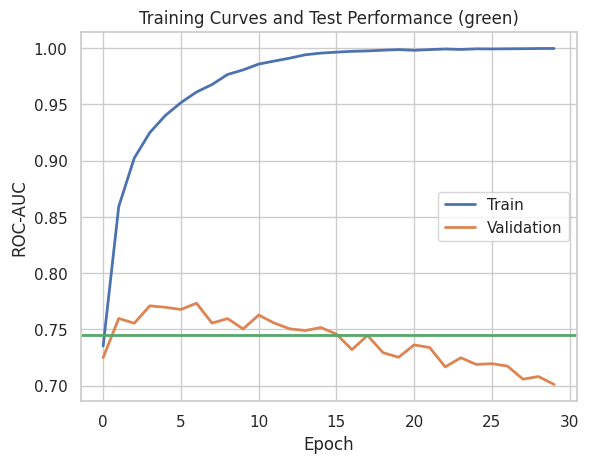

In [ ]:
import matplotlib.pyplot as plt

plt.plot(fptrain_aucs, label="Train", linewidth=2)
plt.plot(fpval_aucs, label="Validation", linewidth=2)
plt.axhline(y=test_auc, color='g', linewidth=2)
plt.plot()

plt.xlabel("Epoch")
plt.ylabel("ROC-AUC")
plt.title("Training Curves and Test Performance (green)")
plt.legend()
plt.show()